# Installation framework

In [1]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from pprint import pprint
from time import sleep

# qcodes imports
import qcodes as qc
from qcodes import (Measurement,
                    experiments,
                    initialise_database,
                    initialise_or_create_database_at,
                    load_by_guid,
                    load_by_run_spec,
                    load_experiment,
                    load_last_experiment,
                    load_or_create_experiment,
                    new_experiment,
                    ManualParameter)
from qcodes.utils.dataset.doNd import do1d, do2d, do0d
from qcodes.dataset.plotting import plot_dataset
from qcodes.logger.logger import start_all_logging
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.utils.validators import Numbers, Arrays
from qcodes.utils.metadata import diff_param_values
from qcodes.instrument.parameter import ParameterWithSetpoints, Parameter, ScaledParameter
from qcodes.interactive_widget import experiments_widget

# OPX import
# QUA imports
from qm.qua import *
from qualang_tools.external_frameworks.qcodes.opx_driver import OPX
from importlib import reload
import configuration
reload(configuration)
from configuration import *
from qualang_tools.loops import from_array

2023-09-15 09:58:52,890 - qm - INFO     - Starting session: 7efd1532-8440-4bd6-8107-e4b1fc794805


### QCoDeS instantiation

In [2]:
db_name = "database.db" # Database name
sample_name = "sample" # Sample name
exp_name = "experiment" # Experiment name

db_file_path = os.path.join(os.getcwd(), db_name)
qc.config.core.db_location = db_file_path
initialise_or_create_database_at(db_file_path)

experiment = load_or_create_experiment(experiment_name = exp_name,
                                       sample_name = sample_name)

station = qc.Station()

### Dummy parameters

In [3]:
#Initializing Quantum Machines (+Dummy) parameters (e.g. setting the Octave LO frequency, setting the Octave RF output gain)
class MyCounter(Parameter):
    def __init__(self, name, label):
        # only name is required
        super().__init__(
            name=name,
            label=label,
            unit="V",
            docstring="Dummy counter for scanning a variable with qcodes",
        )
        self._count = 0

    # you must provide a get method, a set method, or both.
    def get_raw(self):
        # self._count += 1
        return self._count

    def set_raw(self, val):
        self._count = val
        return self._count

#Dummy parameters
VDUM1 = MyCounter("counter1", "Vp1")
VDUM2 = MyCounter("counter2", "Vp2")

### Classes to configure the Octave

In [4]:
class Octave_frequency(Parameter):
    def __init__(self, element, qm):
        # only name is required
        super().__init__(
            name="octave_frequency",
            label="LO frequency",
            unit="Hz",
            docstring="QCoDeS parameter for setting the Octave frequency",
        )
        self._freq = 0
        self.qm = qm
        self.element = element
    # you must provide a get method, a set method, or both.
    def get_raw(self):
        return self.qm.octave.__dict__["_elements_db"]["qubit"].lo_frequency

    def set_raw(self, val):
        self._freq = val
        self.qm.octave.set_lo_frequency(self.element, self._freq)
        print(f"LO freq set to {val / u.GHz} GHz")
        return self._freq
    

class Octave_gain(Parameter):
    def __init__(self, element, qm):
        # only name is required
        super().__init__(
            name="ocatve_gain",
            label="Octave gain",
            unit="dBm",
            docstring="QCodes parameter for scanning the Octave power gain",
        )
        self._pwr = 0
        self.qm = qm
        self.element = element
    # you must provide a get method, a set method, or both.
    def get_raw(self):
        return self._pwr
    
    #sets Octave output gain (in dBm)
    def set_raw(self, val):
        self._pwr = val
        safety = 5
        if val<=safety:
            self.qm.octave.set_rf_output_gain(self.element, self._pwr)
            print("RF output gain set to " + str(val) + " dB")
            return self._pwr
        else: 
            print("Safety value of " + str(safety) + " dB was surpassed; did not set value")
            self._pwr = safety
            return self._pwr

### Octave configuration

In [5]:
port_mapping = {
        ("con1", 1): ("octave1", "I1"),
        ("con1", 2): ("octave1", "Q1"),
        ("con1", 3): ("octave1", "I2"),
        ("con1", 4): ("octave1", "Q2"),
        ("con1", 5): ("octave1", "I3"),
        ("con1", 6): ("octave1", "Q3"),
        ("con1", 7): ("octave1", "I4"),
        ("con1", 8): ("octave1", "Q4"),
        ("con1", 9): ("octave1", "I5"),
        ("con1", 10): ("octave1", "Q5"),
    }
# The Octave port is 11xxx, where xxx are the last three digits of the Octave internal IP that can be accessed from
# the OPX admin panel if you QOP version is >= QOP220. Otherwise, it is 50 for Octave1, then 51, 52 and so on.
octave_1 = OctaveUnit("octave1", qop_ip, port=11050, con="con1", clock="Internal", port_mapping="default")

# Configure the Octave
octave_config = octave_declaration([octave_1])

### Connect to the Quantum Orchestration Platform

In [6]:
# Create the OPX instrument and add it to the qcodes station
opx_instrument = OPX(config, name="OPX_instrument", host=qop_ip, octave=octave_config)
station.add_component(opx_instrument)


2023-09-15 09:58:57,806 - qm - INFO     - Octave "octave1" Health check passed, current temperature 57
2023-09-15 09:58:57,808 - qm - INFO     - Performing health check
2023-09-15 09:58:57,991 - qm - WARNING  - Health check warning: Inter-OPX connectivity issues in OPX: con1. Missing ports are: 4, 3, 2, 1, 12, 11, 10, 9. See QM-App for more info.
2023-09-15 09:58:57,992 - qm - WARNING  - Health check warning: Inter-OPX connectivity issues in OPX: con2. Missing ports are: 4, 3, 2, 1, 12, 11, 10, 9. See QM-App for more info.
2023-09-15 09:58:57,993 - qm - INFO     - Health check passed
Connected to: Quantum Machines OPX+ in 3.07s. QOP Version = 2.60-5ba458f, SDK Version = 1.1.3.


### Initialize the Octave

In [7]:
from set_octave import ElementsSettings, octave_settings
from qm.octave import *

# The gain can be set here and the LO frequency is taken from the config
qubit = ElementsSettings("qubit", gain=-10)
octave_settings(opx_instrument, config=config, octaves=octaves, elements_settings=[qubit], calibration=False)
opx_instrument.qm = opx_instrument.qmm.open_qm(config)  # Need to re-open the QM after calibration to apply the parameters
# Octave frequency and gain
qubit_lo = Octave_frequency("qubit", opx_instrument.qm) # You'll get better performances if set to multiples of 250MHz
qubit_gain = Octave_gain("qubit", opx_instrument.qm)

### Octave calibration

In [8]:
# Set Octave frequency - You'll get better performances if set to multiples of 250MHz 
qubit_lo(8.25e9)
# Set Octave RF gain
qubit_gain(0)
# Calibrate the Octave for a given (LO, IF) pair
opx_instrument.qm.octave.calibrate_element("qubit", [(float(qubit_lo()), float(qubit_IF))])
opx_instrument.qm = opx_instrument.qmm.open_qm(config)  # Need to re-open the QM after calibration to apply the parameters

LO freq set to 8.25 GHz
RF output gain set to 0 dB


### Macro to switch between measurement types

In [8]:
def OPX_measurement(type:str = "reflectometry", I=None, I_st=None, Q=None, Q_st=None):
    if I is None:
        I = declare(fixed)
    if I_st is None:
        I_st = declare_stream()
    if type == "reflectometry":
        if Q is None:
            Q = declare(fixed)   
        if Q_st is None:
            Q_st = declare_stream()     
        measure("readout", "tank_circuit", None, demod.full("cos", I, "out1"), demod.full("sin", Q, "out1"))
        save(I, I_st)
        save(Q, Q_st)
    elif type == "dc_current":
        measure("readout", "TIA", None, integration.full("cos", I, "out1"))
        save(I, I_st)

## Reflectometry scan

### Simple 1D reflectometry scan

In [ ]:
n_avg = 1_000  # Number of averages
# Sweep the readout frequency
freq_array = np.arange(1e6, 350e6, 0.1e6)

#     We are now defining a QUA program  which applies N pulse cycles, averages them n_avg times, for IF frequencies in f_vec
def reflectometry_scan(simulate=True, frequencies=()):
    with program() as prog:
        n = declare(int)
        f = declare(int)
        I = declare(fixed)
        Q = declare(fixed)
        I_st = declare_stream()
        Q_st = declare_stream()

        #     Start an infinite loop. Outer loop: averaging n_avg times > next loop: iterate over frequencies > last loop: do N pulse cycles 
        with infinite_loop_():
            if not simulate:
                pause()

            with for_(n, 0, n < n_avg, n + 1):
                with for_(*from_array(f, frequencies)):
                    update_frequency("tank_circuit", f)
                    measure("readout", "tank_circuit", None, demod.full("cos", I, "out1"), demod.full("sin", Q, "out1"))
                    wait(1000)  # Wait for letting the resonator deplete and for giving enough time to the stream processing to process the data
                    save(I, I_st)
                    save(Q, Q_st)
        with stream_processing():
            # Perform operations from the left to the right and buffering from the most inner looop to the most outer one
            I_st.buffer(len(frequencies)).buffer(n_avg).map(FUNCTIONS.average()).save_all("I")
            Q_st.buffer(len(frequencies)).buffer(n_avg).map(FUNCTIONS.average()).save_all("Q")
    return prog


opx_instrument.qua_program = reflectometry_scan(simulate=False, frequencies=freq_array)
opx_instrument.set_sweep_parameters("axis1", freq_array, unit="Hz", label="RF frequency")
opx_instrument.readout_pulse_length(reflectometry_readout_length)
do0d(
    opx_instrument.run_exp,
    opx_instrument.resume,
    opx_instrument.get_measurement_parameter(),
    opx_instrument.halt,
    do_plot=True,
    exp=experiment,
)

### Resonator spectroscopy versus readout amplitude

In [ ]:
n_avg = 1_000   # Number of averages
# Sweep the frequency around the resonance
freq_array = np.arange(-10e6, 10e6, 0.1e6)
# Sweep the readout amplitude - this is a pre-factor multiplied to the amplitude defined in the config - must be within [-2, 2)
amp_array = np.linspace(0.01, 1.99, 21)
#     We are now defining a QUA program  which applies N pulse cycles, averages them n_avg times, for IF frequencies in f_vec
def reflectometry_scan_2d(simulate=True, frequencies=(), amplitudes=()):
    with program() as prog:
        n = declare(int)
        f = declare(int)
        a = declare(fixed)
        I = declare(fixed)
        Q = declare(fixed)
        I_st = declare_stream()
        Q_st = declare_stream()

        #     Start an infinite loop. Outer loop: averaging n_avg times > next loop: iterate over frequencies > last loop: do N pulse cycles 
        with infinite_loop_():
            if not simulate:
                pause()

            with for_(n, 0, n < n_avg, n + 1):
                with for_(*from_array(f, frequencies)):
                    update_frequency("qubit", f + resonator_IF)
                    with for_(*from_array(a, amplitudes)):
                        measure("readout" * amp(a), "tank_circuit", None, demod.full("cos", I, "out1"), demod.full("sin", Q, "out1"))
                        wait(1000)
                        save(I, I_st)
                        save(Q, Q_st)
        with stream_processing():
            I_st.buffer(len(amplitudes)).buffer(len(frequencies)).buffer(n_avg).map(FUNCTIONS.average()).save_all("I")
            Q_st.buffer(len(amplitudes)).buffer(len(frequencies)).buffer(n_avg).map(FUNCTIONS.average()).save_all("Q")
    return prog


opx_instrument.qua_program = reflectometry_scan_2d(simulate=False, frequencies=freq_array, amplitudes=amp_array)
opx_instrument.set_sweep_parameters("axis1", amp_array * reflect_amp, unit="V", label="Readout amplitude")
opx_instrument.set_sweep_parameters("axis2", freq_array + resonator_IF, unit="Hz", label="RF frequency")
opx_instrument.readout_pulse_length(reflectometry_readout_length)
do0d(
    opx_instrument.run_exp,
    opx_instrument.resume,
    opx_instrument.get_measurement_parameter(),
    opx_instrument.halt,
    do_plot=True,
    exp=experiment,
)

## Charge stability map

### Swee the gates with qcodes and measure with the OPX

In [ ]:
n_avg = 1_000  # Number of averages
# Measurement type to select the correct measure statement - can be either "reflectometry" or "dc_current"
measurement_type = "reflectometry"
simulate = False
#     We are now defining a QUA program  which applies N pulse cycles, averages them n_avg times, for IF frequencies in f_vec
def reflectometry_scan(simulate=True, frequencies=()):
    with program() as prog:
        n = declare(int)
        I = declare(fixed)
        Q = declare(fixed)
        I_st = declare_stream()
        Q_st = declare_stream()

        #     Start an infinite loop. Outer loop: averaging n_avg times > next loop: iterate over frequencies > last loop: do N pulse cycles 
        with infinite_loop_():
            if not simulate:
                pause()

            with for_(n, 0, n < n_avg, n + 1):
                OPX_measurement(measurement_type, I, I_st, Q, Q_st)
                wait(1000)
        with stream_processing():
            I_st.buffer(n_avg).map(FUNCTIONS.average()).save_all("I")
            if measurement_type == "reflectometry":
                Q_st.buffer(n_avg).map(FUNCTIONS.average()).save_all("Q")
    return prog


opx_instrument.qua_program = reflectometry_scan(simulate=False, frequencies=freq_array)
if measurement_type == "reflectometry":
    opx_instrument.readout_pulse_length(reflectometry_readout_length)
else:
    opx_instrument.readout_pulse_length(readout_len)
VP1 = MyCounter("P1", "VP1")
VP2 = MyCounter("P2", "VP2")
do2d(
    VP1,
    0.02,
    0.04,
    10,
    0.1,
    VP2, 
    0.220,
    0.240,
    11,
    0.1,
    opx_instrument.resume,
    opx_instrument.get_measurement_parameter(),
    enter_actions=[opx_instrument.run_exp],
    exit_actions=[opx_instrument.halt],
    show_progress=True,
    do_plot=True,
    exp=experiment,
)

## Rabi scans

### Find the qubit frequency by sweeping the Octave LO and OPX IF

In [ ]:
n_avg = 1_000   # Number of averages
# Sweep the qubit drive frequency in Hz
freq_IF = np.arange(-250e6, 250.5e6, 1e6)
f_min_octave = 3e9 - min(freq_IF)
f_max_octave = 8e9 - max(freq_IF)
df_external = max(freq_IF) - min(freq_IF)
freqs_LO = np.arange(f_min_octave, f_max_octave + 0.1, df_external)
n_LOs = len(freqs_LO)
# Qubit drive length
pulse_length = 100 * u.ns
# VP1 pulse length
bias_length = 200 * u.ns
# Measurement type to select the correct measure statement - can be either "reflectometry" or "dc_current"
measurement_type = "reflectometry"
# Flag to simulate or execute the QUA program
simulate = False

#     We are now defining a QUA program  which applies N pulse cycles, averages them n_avg times, for IF frequencies in f_vec
def qubit_spectroscopy_wide(simulate=True, frequencies=()):
    with program() as prog:
        n = declare(int)
        f = declare(int)
        I = declare(fixed)
        Q = declare(fixed)
        I_st = declare_stream()
        Q_st = declare_stream()

        #     Start an infinite loop. Outer loop: averaging n_avg times > next loop: iterate over frequencies > last loop: do N pulse cycles 
        with infinite_loop_():
            if not simulate:
                pause()

            with for_(n, 0, n < n_avg, n + 1):
                with for_(*from_array(f, frequencies)):
                    update_frequency("qubit", f)
                    play("bias", "P1", duration=bias_length * u.ns)
                    wait(20 // 4, "qubit")
                    play("cw", "qubit", duration=pulse_length * u.ns)
                    play("bias"*amp(-1), "P1", duration=bias_length * u.ns)
                    align()
                    OPX_measurement(measurement_type, I, I_st, Q, Q_st)
                    wait(1000)
        with stream_processing():
            I_st.buffer(len(frequencies)).buffer(n_avg).map(FUNCTIONS.average()).save_all("I")
            Q_st.buffer(len(frequencies)).buffer(n_avg).map(FUNCTIONS.average()).save_all("Q")
    return prog



if simulate:
    opx_instrument.qua_program = qubit_spectroscopy_wide(simulate=False, frequencies=freq_IF)
    # Simulate program
    opx_instrument.sim_time(10_000)
    opx_instrument.simulate()
    opx_instrument.plot_simulated_wf()
else:
    opx_instrument.qua_program = qubit_spectroscopy_wide(simulate=False, frequencies=freq_IF)
    opx_instrument.set_sweep_parameters("axis1", freq_IF, unit="Hz", label="Qubit IF")
    if measurement_type == "reflectometry":
        opx_instrument.readout_pulse_length(reflectometry_readout_length)
    elif measurement_type == "dc_current":
        opx_instrument.readout_pulse_length(readout_length)
    do1d(
        qubit_lo,
        f_min_octave,
        f_max_octave,
        n_LOs,
        1,
        opx_instrument.resume,
        opx_instrument.get_measurement_parameter(),
        enter_actions=[opx_instrument.run_exp],
        exit_actions=[opx_instrument.halt],
        do_plot=True,
        exp=experiment,
    )

### Scan Rabi pulse duration with standard realtime QUA

In [ ]:
n_avg = 1_000   # Number of averages
# Sweep the qubit drive frequency in Hz
freq_array = np.arange(-10e6, 10e6, 0.1e6)
# Sweep the Rabi pulse duration - in clock cycles = 4ns - must be > 4 clock cycles
t_array = np.arange(1000, 4, -1)
# P1 pulse duration - should be larger than the maximum Rabi pulse duration
bias_length = max(t_array) + 20
# Measurement type to select the correct measure statement - can be either "reflectometry" or "dc_current"
measurement_type = "reflectometry"
# Flag to simulate or execute the QUA program
simulate = False
#     We are now defining a QUA program  which applies N pulse cycles, averages them n_avg times, for IF frequencies in f_vec
def reflectometry_scan_2d(simulate=True, frequencies=(), durations=()):
    with program() as prog:
        n = declare(int)
        f = declare(int)
        t = declare(int)
        I = declare(fixed)
        Q = declare(fixed)
        I_st = declare_stream()
        Q_st = declare_stream()

        #     Start an infinite loop. Outer loop: averaging n_avg times > next loop: iterate over frequencies > last loop: do N pulse cycles 
        with infinite_loop_():
            if not simulate:
                pause()

            with for_(n, 0, n < n_avg, n + 1):
                with for_(*from_array(f, frequencies)):
                    update_frequency("qubit", f)
                    with for_(*from_array(t, durations)):                        
                        play("bias", "P1", duration=bias_length * u.ns)
                        wait(20 // 4, "qubit")
                        play("cw", "qubit", duration=t)
                        play("bias"*amp(-1), "P1", duration=bias_length * u.ns)
                        align()
                        OPX_measurement(measurement_type, I, I_st, Q, Q_st)
                        wait(1000)
        with stream_processing():
            I_st.buffer(len(durations)).buffer(len(frequencies)).buffer(n_avg).map(FUNCTIONS.average()).save_all("I")
            if measurement_type == "reflectometry":
                Q_st.buffer(len(durations)).buffer(len(frequencies)).buffer(n_avg).map(FUNCTIONS.average()).save_all("Q")
    return prog

if simulate:
    opx_instrument.qua_program = reflectometry_scan_2d(simulate=True, frequencies=freq_array, durations=t_array)
    # Simulate program
    opx_instrument.sim_time(10_000)
    opx_instrument.simulate()
    opx_instrument.plot_simulated_wf()
else:
    opx_instrument.qua_program = reflectometry_scan_2d(simulate=False, frequencies=freq_array, durations=t_array)
    opx_instrument.set_sweep_parameters("axis1", t_array * 4, unit="ns", label="Rabi pulse duration")
    opx_instrument.set_sweep_parameters("axis2", freq_array, unit="Hz", label="Qubit frequency")
    if measurement_type == "reflectometry":
        opx_instrument.readout_pulse_length(reflectometry_readout_length)
    elif measurement_type == "dc_current":
        opx_instrument.readout_pulse_length(readout_length)
    do0d(
        opx_instrument.run_exp,
        opx_instrument.resume,
        opx_instrument.get_measurement_parameter(),
        opx_instrument.halt,
        do_plot=True,
        exp=experiment,
    )

### Changing parameters using iovalues

In [17]:
n_avg = 1_000   # Number of averages
# Sweep the qubit drive frequency in Hz
freq_array = np.arange(-10e6, 10e6, 0.1e6)
# Sweep the Rabi pulse duration - in clock cycles = 4ns - must be > 4 clock cycles
t_array = np.arange(1000, 4, -1)
# P1 pulse duration - should be larger than the maximum Rabi pulse duration
bias_length = max(t_array) + 20
# Measurement type to select the correct measure statement - can be either "reflectometry" or "dc_current"
measurement_type = "reflectometry"
# Flag to simulate or execute the QUA program
simulate = False

class io_parameter(Parameter):
    def __init__(self, qm, name, label, unit, config_amp):
        # only name is required
        super().__init__(
            name=name,
            label=label,
            unit=unit,
            docstring="QCoDeS parameter for setting QUA variables while the program is running",
        )
        self._value = 0
        self.qm = qm
        self.config_amp = config_amp
    # you must provide a get method, a set method, or both.
    def get_raw(self):
        return self._value

    def set_raw(self, val):
        self._value = val
        if np.abs(val / self.config_amp) >= 2:
            raise ValueError("The pre-factor must be within [-2; 2)]")
        else:
            self.qm.set_io1_value(val / self.config_amp)
        print(f"{self.name} set to {val} {self.unit} (pre-factor={val / self.config_amp})")
        if self.qm.get_running_job() is None:
            raise RuntimeError("You can only set iovalues when a job is running.")
        else:
            self.qm.get_running_job().resume()
        return self._value
    
pi_amplitude = io_parameter(opx_instrument.qm, "pi_amplitude", "pi_amp", "V", pi_amp)

    
#     We are now defining a QUA program  which applies N pulse cycles, averages them n_avg times, for IF frequencies in f_vec
def reflectometry_scan_2d(simulate=True, frequencies=(), durations=()):
    with program() as prog:
        n = declare(int)
        f = declare(int)
        t = declare(int)
        I = declare(fixed)
        Q = declare(fixed)
        pi_amp_prefactor = declare(fixed)
        I_st = declare_stream()
        Q_st = declare_stream()

        #     Start an infinite loop. Outer loop: averaging n_avg times > next loop: iterate over frequencies > last loop: do N pulse cycles 
        with infinite_loop_():
            if not simulate:
                pause()
                assign(pi_amp_prefactor, IO1)

            with for_(n, 0, n < n_avg, n + 1):
                with for_(*from_array(t, durations)):                        
                    play("bias", "P1", duration=bias_length * u.ns)
                    wait(20 // 4, "qubit")
                    play("cw", "qubit", duration=t)
                    play("bias"*amp(-1), "P1", duration=bias_length * u.ns)
                    align()
                    OPX_measurement(measurement_type, I, I_st, Q, Q_st)
                    wait(1000)
        with stream_processing():
            I_st.buffer(len(durations)).buffer(n_avg).map(FUNCTIONS.average()).save_all("I")
            if measurement_type == "reflectometry":
                Q_st.buffer(len(durations)).buffer(n_avg).map(FUNCTIONS.average()).save_all("Q")
    return prog

if simulate:
    opx_instrument.qua_program = reflectometry_scan_2d(simulate=True, frequencies=freq_array, durations=t_array)
    # Simulate program
    opx_instrument.sim_time(10_000)
    opx_instrument.simulate()
    opx_instrument.plot_simulated_wf()
else:
    opx_instrument.qua_program = reflectometry_scan_2d(simulate=False, frequencies=freq_array, durations=t_array)
    opx_instrument.set_sweep_parameters("axis1", t_array * 4, unit="ns", label="Rabi pulse duration")
    opx_instrument.set_sweep_parameters("axis2", freq_array, unit="Hz", label="Qubit frequency")
    if measurement_type == "reflectometry":
        opx_instrument.readout_pulse_length(reflectometry_readout_length)
    elif measurement_type == "dc_current":
        opx_instrument.readout_pulse_length(readout_length)
    do1d(
        pi_amplitude,
        0,
        0.19,
        10,
        1,
        opx_instrument.resume,
        opx_instrument.get_measurement_parameter(),
        enter_actions=[opx_instrument.run_exp],
        exit_actions=[opx_instrument.halt],
        do_plot=True,
        exp=experiment,
    )

2023-09-15 10:06:56,399 - qm - INFO     - Sending program to QOP for compilation
2023-09-15 10:06:56,857 - qm - INFO     - Executing program
Starting experimental run with id: 32. Using 'qcodes.dataset.do1d'
pi_amplitude set to 0.0 V (pre-factor=0.0)
pi_amplitude set to 0.022222222222222223 V (pre-factor=0.2222222222222222)
pi_amplitude set to 0.044444444444444446 V (pre-factor=0.4444444444444444)
pi_amplitude set to 0.06666666666666667 V (pre-factor=0.6666666666666666)
pi_amplitude set to 0.08888888888888889 V (pre-factor=0.8888888888888888)
pi_amplitude set to 0.11111111111111112 V (pre-factor=1.1111111111111112)
pi_amplitude set to 0.13333333333333333 V (pre-factor=1.3333333333333333)
pi_amplitude set to 0.15555555555555556 V (pre-factor=1.5555555555555556)
pi_amplitude set to 0.17777777777777778 V (pre-factor=1.7777777777777777)


ValueError: ('The pre-factor must be within [-2; 2)]', 'setting pi_amplitude to 0.2')

### Using the baking tool for 1ns granularity

In [ ]:
# Create the baked sequence
from qualang_tools.bakery import baking

wait_time = 5  # ns
t_min = 0  # ns
t_max = 40  # ns
dt = 1  # ns
t_vec = np.arange(t_min, t_max + dt / 2, dt)
sample_rate = round(1 / dt * 1e9)

# Stores the baking objects
pi_list = []
for t in t_vec:  # Create the different baked sequences
    t = int(t)
    # need to verify (assert?) that the baked waveform:
    # 1. form a multiple of 4 ns. Here, by construction it's 4*t + 2 * pi_len = 4(t + pi_len/2),
    #    so it's enough to require that pi_len is even
    # 2. the entire waveform is >= 16 ns (4 cycles). Here t >= 1 so 2*pi_len >= 12 is required,
    # HOWEVER, due to a different limitation, pi_len >= 16 is currently  required (will work to fix that)
    with baking(opx_instrument.config, sampling_rate=sample_rate, padding_method="none") as b:  # don't use padding to assure error if timing is incorrect
        if t == 0:
            wf_I = [0.0] * 16; wf_Q = [0.0] * 16  # Otherwise the baked pulse will be empty
        else:
            wf_I = [pi_amp] * t; wf_Q = [0.0] * t
        remainder = 16 - (t + wait_time) % 16
        b.add_op("pi_baked", "qubit", [wf_I, wf_Q])
        b.wait(wait_time, "qubit")
        b.play("pi_baked", "qubit")
        b.wait(remainder, "qubit")
    # Append the baking object in the list to call it from the QUA program
    pi_list.append(b)

In [ ]:
n_avg = 1_000   # Number of averages
# Sweep the qubit drive frequency in Hz
freq_array = np.arange(-10e6, 10e6, 0.1e6)
# P1 pulse duration - should be larger than the maximum Rabi pulse duration
bias_length = max(t_vec) + 20
# Measurement type to select the correct measure statement - can be either "reflectometry" or "dc_current"
measurement_type = "reflectometry"
# Flag to simulate or execute the QUA program
simulate = True
#     We are now defining a QUA program  which applies N pulse cycles, averages them n_avg times, for IF frequencies in f_vec
def reflectometry_scan_2d(simulate=True, frequencies=(), durations=()):
    with program() as prog:
        n = declare(int)
        f = declare(int)
        i = declare(int)
        I = declare(fixed)
        Q = declare(fixed)
        I_st = declare_stream()
        Q_st = declare_stream()

        #     Start an infinite loop. Outer loop: averaging n_avg times > next loop: iterate over frequencies > last loop: do N pulse cycles 
        with infinite_loop_():
            if not simulate:
                pause()

            with for_(n, 0, n < n_avg, n + 1):
                with for_(*from_array(f, frequencies)):
                    update_frequency("qubit", f)
                    with for_(i, 0, i < len(t_vec), i + 1):                        
                        play("bias", "P1", duration=bias_length)
                        # the baking switch case
                        with switch_(i, unsafe=True):
                            for ii in range(len(durations)):
                                with case_(ii):
                                    pi_list[ii].run()
                        play("bias"*amp(-1), "P1", duration=bias_length)
                        align()
                        OPX_measurement(measurement_type, I, I_st, Q, Q_st)
                        wait(1000)
        with stream_processing():
            I_st.buffer(len(durations)).buffer(len(frequencies)).buffer(n_avg).map(FUNCTIONS.average()).save_all("I")
            if measurement_type == "reflectometry":
                Q_st.buffer(len(durations)).buffer(len(frequencies)).buffer(n_avg).map(FUNCTIONS.average()).save_all("Q")
    return prog

if simulate:
    opx_instrument.qua_program = reflectometry_scan_2d(simulate=True, frequencies=freq_array, durations=t_vec)
    # Simulate program
    opx_instrument.sim_time(100000)
    opx_instrument.simulate()
    opx_instrument.plot_simulated_wf()
else:
    opx_instrument.qua_program = reflectometry_scan_2d(simulate=False, frequencies=freq_array, durations=t_vec)
    opx_instrument.set_sweep_parameters("axis1", t_vec, unit="ns", label="Rabi pulse duration")
    opx_instrument.set_sweep_parameters("axis2", freq_array, unit="Hz", label="Qubit frequency")
    if measurement_type == "reflectometry":
        opx_instrument.readout_pulse_length(reflectometry_readout_length)
    elif measurement_type == "dc_current":
        opx_instrument.readout_pulse_length(readout_length)
    do0d(
        opx_instrument.run_exp,
        opx_instrument.resume,
        opx_instrument.get_measurement_parameter(),
        opx_instrument.halt,
        do_plot=True,
        exp=experiment,
    )

### Ramsey with short gates (baking)

In [37]:
# Create the baked sequence
from qualang_tools.bakery import baking

wait_time = 5  # ns
pi_len = 7 # ns
t_min = 5  # ns
t_max = 20  # ns
dt = 1  # ns
t_vec = np.arange(t_min, t_max + dt / 2, dt)
sample_rate = round(1 / dt * 1e9)

# Stores the baking objects
pi_list = []
for t in t_vec:  # Create the different baked sequences
    t = int(t)
    with baking(opx_instrument.config, sampling_rate=sample_rate, padding_method="none") as b:  # don't use padding to assure error if timing is incorrect
        # Derive the gate waveforms (here pi/2 of length given by pi_len and amplitude given by pi_half_amp)
        wf_I = [pi_half_amp] * pi_len; wf_Q = [0.0] * pi_len
        # Derive the total durtion of the baked sequence
        total_time = t + wait_time + 2*pi_len
        # Get the remainder for having a multiple of 4ns
        remainder = 4 - total_time % 4
        # Ensure that the baked sequence is longer than 16ns
        if (t + wait_time + 2*pi_len + remainder) < 16:
            remainder += 16-(t + wait_time + 2*pi_len + remainder)
        # Add the baked gate to the config
        b.add_op("baked_Op_", "qubit", [wf_I, wf_Q])
        # Write the full baked sequence
        b.wait(wait_time, "qubit")  # Wait after setting VP1
        b.play("baked_Op_", "qubit")  # First pi/2
        b.wait(t, "qubit")  # Wait Ramsey idle time
        b.play("baked_Op_", "qubit")  # 2nd pi/2
        b.wait(remainder, "qubit")  # Add remainder to get a sequence that lasts a multiple of 4ns

    # Append the baking object in the list to call it from the QUA program
    pi_list.append(b)
# Update the QM with the new config
opx_instrument.qm = opx_instrument.qmm.open_qm(opx_instrument.config)

Starting experimental run with id: 31. Using 'qcodes.dataset.do0d'
2023-09-11 15:04:11,557 - qm - INFO     - Sending program to QOP for compilation
2023-09-11 15:04:12,107 - qm - INFO     - Executing program


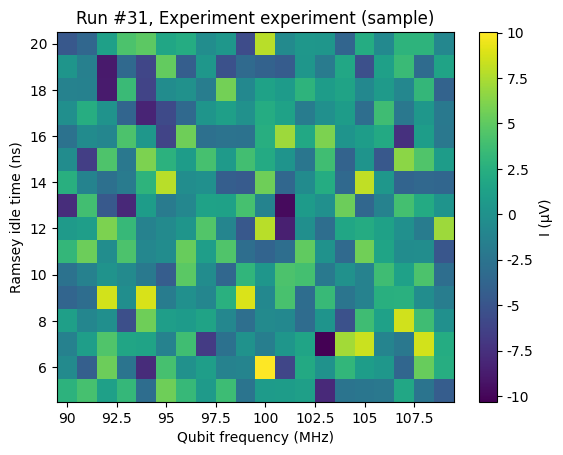

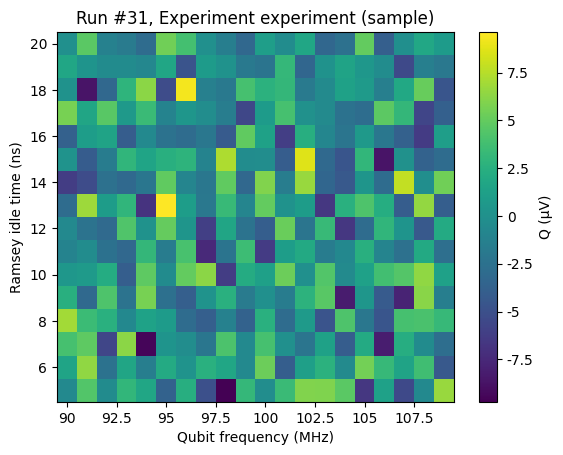

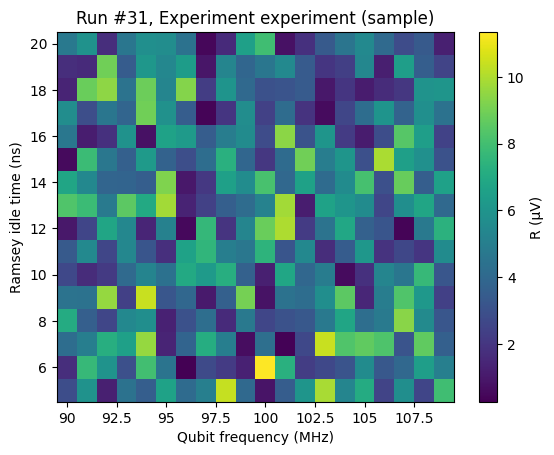

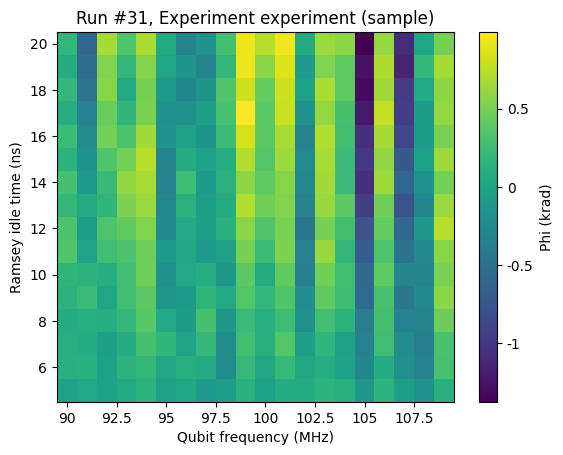

In [38]:
n_avg = 10  # Number of averages
# Sweep the qubit drive frequency around qubit_IF in Hz
freq_array = np.arange(-10e6, 10e6, 1e6)
# P1 pulse duration - should be larger than the maximum Rabi pulse duration
bias_length = max(t_vec) + 20
# Measurement type to select the correct measure statement - can be either "reflectometry" or "dc_current"
measurement_type = "reflectometry"
# Flag to simulate or execute the QUA program
simulate = False
#     We are now defining a QUA program  which applies N pulse cycles, averages them n_avg times, for IF frequencies in f_vec
def ramsey_chevron(simulate=True, frequencies=(), durations=()):
    with program() as prog:
        n = declare(int)
        f = declare(int)
        i = declare(int)
        I = declare(fixed)
        Q = declare(fixed)
        I_st = declare_stream()
        Q_st = declare_stream()

        #     Start an infinite loop. Outer loop: averaging n_avg times > next loop: iterate over frequencies > last loop: do N pulse cycles 
        with infinite_loop_():
            if not simulate:
                pause()

            with for_(n, 0, n < n_avg, n + 1):
                with for_(*from_array(f, frequencies)):
                    update_frequency("qubit", f + qubit_IF)
                    with for_(i, 0, i < len(t_vec), i + 1):                        
                        play("bias", "P1", duration=bias_length)
                        # the baking switch case
                        with switch_(i, unsafe=True):
                            for ii in range(len(durations)):
                                with case_(ii):
                                    pi_list[ii].run()
                        play("bias"*amp(-1), "P1", duration=bias_length)
                        align()
                        OPX_measurement(measurement_type, I, I_st, Q, Q_st)
                        wait(1000)
        with stream_processing():
            I_st.buffer(len(durations)).buffer(len(frequencies)).buffer(n_avg).map(FUNCTIONS.average()).save_all("I")
            if measurement_type == "reflectometry":
                Q_st.buffer(len(durations)).buffer(len(frequencies)).buffer(n_avg).map(FUNCTIONS.average()).save_all("Q")
    return prog

if simulate:
    opx_instrument.qua_program = ramsey_chevron(simulate=True, frequencies=freq_array, durations=t_vec)
    # Simulate program
    opx_instrument.sim_time(1000)
    opx_instrument.simulate()
    opx_instrument.plot_simulated_wf()
    plt.xlim((500, 600))
else:
    opx_instrument.qua_program = ramsey_chevron(simulate=False, frequencies=freq_array, durations=t_vec)
    opx_instrument.set_sweep_parameters("axis1", t_vec, unit="ns", label="Ramsey idle time")
    opx_instrument.set_sweep_parameters("axis2", freq_array + qubit_IF, unit="Hz", label="Qubit frequency")
    if measurement_type == "reflectometry":
        opx_instrument.readout_pulse_length(reflectometry_readout_length)
    elif measurement_type == "dc_current":
        opx_instrument.readout_pulse_length(readout_length)
    do0d(
        opx_instrument.run_exp,
        opx_instrument.resume,
        opx_instrument.get_measurement_parameter(),
        opx_instrument.halt,
        do_plot=True,
        exp=experiment,
    )